## 畳み込み

畳み込みとは

あるピクセルと隣接するピクセルとの荷重和を作成する計算である。
この計算により、局所的なパターンが画像内の物体位置に関わらず出力に効果的である。

重み行列（カーネル）のスカラー積を出力していく
カーネルサイズは一般的に小さなサイズを使用し、二次元画像には３＊３、RBGの画像には３＊３＊３のカーネルが使用される。

カーネルの重みはnn.Linearの重みと同様に学習してい値である。そしてこのカーネルの重みは画像全体に渡り利用される。
そのためカーネルの重みは画像全体から影響を受けることになる。

全結合層を畳み込みに変更することで、下記のメリットがある

１．近傍における局所的な演算処理
２．移動不変性
３．パラメータを大幅に削減したモデル

## 畳み込みの使用

In [12]:
from torchvision import datasets
import torch
import torch.nn as nn
from torchvision import transforms


from matplotlib import pyplot as plt
import numpy as np

出力チャネルのサイズは任意の値が選択できる。
このチャネルの数が増えるほどパラメータが増加し、特徴量の検出も増大する。

カーネルのサイズはすべての方向に同じことが一般的だが、CTのボクセルのうち一つが異なる解像度であるような場合は、例外的に異なるサイズを使用する。

In [8]:
conv = nn.Conv2d(3, 16, kernel_size=3)
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [9]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [13]:
data_path = "../data/p1ch7/"
#引数は保存のパス、訓練用かテスト用か、pytorchで保存して良いか
#他にもSVHN ,COCO,Ominglotなどがある
cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [14]:
cifar10 = datasets.CIFAR10(
            data_path, train=True, download=False, 
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.4915, 0.4823, 0.4468),
                                     (0.1470, 0.2435, 0.2626))
            ]))

In [15]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

In [16]:
#cifar10の中から飛行機と鳥のみのdatasetsにする
label_map = {0:0, 2:1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0,2]]
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0,2]]

In [20]:
img, _ = cifar2[0]
img.shape

torch.Size([3, 32, 32])

In [21]:
output = conv(img.unsqueeze(0))
img.unsqueeze((0)).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

In [23]:
output[0, 0].shape

torch.Size([30, 30])

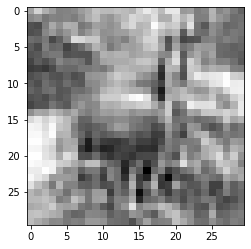

In [24]:
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

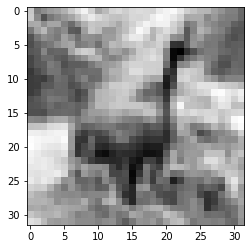

In [26]:
plt.imshow(img[0], cmap='gray')
plt.show()

入力に対して出力の画像サイズが小さくなっている。

## 境界のパディング

畳み込み処理では全ての方向に隣接したピクセルが存在する必要がある。
角の位置では上下どちらか、左右どちらかが存在しない。デフォルトではPyTorchではwidth - kernl_width +1 の位置までを取得する。
奇数サイズのカーネルではカーネルの幅の半分（今回は3//2=1)だけ各境界が小さくなった画像が出力された。

pytorchでは畳み込み時に境界領域にゼロになｋる架空のピクセルを作成して画像をパディングできる。
今回の件ではkernel_size=3*3, padeing=1 を指定するともとの画像と同じサイズの出力が得られる。

In [28]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
output = conv(img.unsqueeze(0))

In [29]:
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

画像サイズが変化しないことはスキップ接続や複雑な構造のモデルでテンソル同士の加減算が可能になる。

## 畳み込みの学習

手動でのパラメータ設定

In [31]:
#バイアスをゼロにする
with torch.no_grad():
    conv.bias.zero_()
    
with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)

In [32]:
conv.weight

Parameter containing:
tensor([[[[0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111]],

         [[0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111]],

         [[0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111]]]], requires_grad=True)